<a href="https://colab.research.google.com/github/ramirojc/Georeferenced_Feature_Engineering/blob/master/Georef_FeatureEng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Generation based on georeferenced GIS Data with Geopandas

In this notebook we are going to go throught diferents approachs to generate features from GIS data. 

The dataset we are using corresponds to the electrical power infrastructure from Sulgipe - Companhia Sul Sergipana de Eletricidade , a small distributor from Brazil.

The information is stored as a multilayer GDB database, that includes:
 - UNTRD, Distribution Transformers Units, Medium to lower voltage transformers.
 - UNTRS, SubStation Transformers Units, High to Medium voltage transformers.
 - UCBT, Low Tension Consumer.
 - SSMT, Medium Voltage distribution power lines.

We are going to use GeoPandas to handle the information and perform basic processing tasks, and the cKDTree module of SciPy to construct spatial search trees.

## Libraries instalation


In [ ]:
# GeoPandas instalation 
!pip install geopandas

# We need to install this dependencies for CKDTree to perform properly
!apt install libspatialindex-dev
!pip install rtree

# Contextily allows to display a maptiles background to geopandas plots
!pip install contextily

## Loading the data


In [ ]:
import geopandas as gpd
import pandas as pd
import contextily as ctx

 The dataset can be download from Brazilian National Energy Website, https://www.aneel.gov.br/ , or for easier access you can reference it from this link: 
 
https://drive.google.com/file/d/1sOE8Y-VZaM99MFM01YJq-4N0Yw89_9gS/view?usp=sharing

The folder name must end with '.gdb' so GeoPandas recognize it as a GDB database.

In [ ]:
data_path = './drive/My Drive/BDGD/SULGIPE_46_2018-12-31_M10_20190611-1750.gdb'

In [ ]:
untrs = gpd.read_file(data_path, driver='FileGDB', layer='UNTRS')
untrd = gpd.read_file(data_path, driver='FileGDB', layer='UNTRD')
ssmt = gpd.read_file(data_path, driver='FileGDB', layer='SSDMT')

((6, 9), Index(['COD_ID', 'DIST', 'NOM', 'SIST_INTE', 'SIST_SUBT', 'DESCR',
        'Shape_Length', 'Shape_Area', 'geometry'],
       dtype='object'))

## Setting the Coordinates Reference System, CRS.

GeoPandas loads the data to a GeoDataframe, this structure is similar to a Pandas DataFrame but adds some extra functionality. For example, we'll have a special columns named 'geometry' that wil hold to geografical representation of each row as a Shapely object (We'll not enter in details about them but you can get more details on https://shapely.readthedocs.io/en/latest/manual.html). 

This representation it's based on a coordenates reference system, for example WGS84 - EPSG:4326, is the one used by GPS system.

Let see an example from:
https://geopandas.org/projections.html

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [ ]:
world.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Now we can plot the data in this projection.

Text(0.5, 1.0, 'WGS 84 - EPSG 4326')

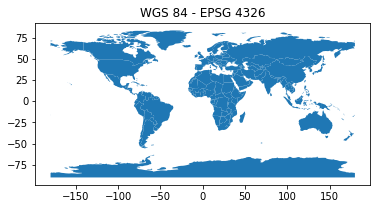

In [ ]:
ax = world.plot()
ax.set_title('WGS 84 - EPSG 4326')

Geopandas allows us to change the CRS quite easily. Let's re-project to the Mercator Projection CRS, EPSG 3395.

Text(0.5, 1.0, 'Mercator - EPSG 3395')

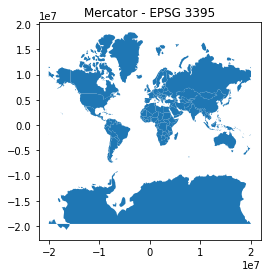

In [ ]:
ax = world.to_crs('EPSG:3395').plot()
ax.set_title('Mercator - EPSG 3395')

We can clearly see how the graphical representation is modified.

In [ ]:
pd.concat([world.geometry, world.to_crs('EPSG:3395').geometry], axis=1).head()

,geometry,geometry
0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...","MULTIPOLYGON (((20037508.343 -1800679.237, 200..."
1,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...","POLYGON ((3774143.866 -105050.440, 3792946.708..."
2,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...","POLYGON ((-964649.018 3185897.152, -964597.245..."
3,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...","MULTIPOLYGON (((-13674486.249 6242596.000, -13..."
4,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...","MULTIPOLYGON (((-13674486.249 6242596.000, -13..."


### Convert to a local metric system

We are going to calculate distance, so we want a CRS representation in meters instead of degrees. For this will first find the UTM corresponding to our data in https://www.latlong.net/lat-long-utm.html , the result is 24S (24L).

With this information we search an UTM system in https://epsg.io/ and find that the correct system is EPSG 31984.

Now we convert all our GeoDataFrames to this CRS

In [ ]:
conj.crs

<Geographic 2D CRS: EPSG:4674>
Name: SIRGAS 2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Latin America - SIRGAS 2000 by country
- bounds: (-122.19, -59.87, -25.28, 32.72)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
conj = conj.to_crs(epsg=31984)
untrs = untrs.to_crs(epsg=31984)
untrd = untrd.to_crs(epsg=31984)
ssmt = ssmt.to_crs(epsg=31984)

In [ ]:
conj.crs

<Projected CRS: EPSG:31984>
Name: SIRGAS 2000 / UTM zone 24S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - 42°W to 36°W
- bounds: (-42.0, -26.35, -36.0, 0.74)
Coordinate Operation:
- name: UTM zone 24S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## Feature Generation based on distances to keypoints



### Euclidian Distance to points in the dataset

The first thing we can do it's to get the distance to keypoints already available in the dataset. In this case we'll use the UNTRS (High Voltage Transformerss).

We could apply this idea in housing data, getting the distance to more valuable, or bigger houses; in farming to be the distances to areas with the highest returns, etc.

For this we use the 'distance' method, we can pass one reference or a vector the same size of the dataset for one-to-one calculations.

In [ ]:
for i, trs in enumerate(untrs.geometry.unique()): untrd[f'dist2trs{i}'] = untrd.distance(trs)

untrd.head()

,COD_ID,DIST,PAC_1,PAC_2,PAC_3,FAS_CON_P,FAS_CON_S,FAS_CON_T,SIT_ATIV,TIP_UNID,POS,ATRB_PER,TEN_LIN_SE,CAP_ELO,CAP_CHA,TAP,CONF,POSTO,POT_NOM,PER_FER,PER_TOT,DAT_CON,CTMT,UNI_TR_S,SUB,CONJ,MUN,BANC,TIP_TRAFO,MRT,DESCR,ARE_LOC,geometry,trs_0,trs_1,trs_2,trs_3,trs_4,trs_5,dist2trs0,dist2trs1,dist2trs2,dist2trs3,dist2trs4,dist2trs5
0,4_1040341,46,452971,ET4_1040341,0,ABC,ABCN,0,AT,38,PD,1,0.22,05H,1,1.0,RA,PT,15.0,100.0,440.0,30/09/2010,2_SESAQ_1,1_SESAQ_1,SESAQ,12737,2805802,0,T,0,,NU,POINT (627712.617 8776098.670),33373.033284,22651.542996,31083.768215,6030.232571,58865.083741,47745.326303,33373.033284,22651.542996,31083.768215,6030.232571,58865.083741,47745.326303
1,4_1040306,46,452681,ET4_1040306,0,ABC,ABCN,0,AT,38,PD,1,0.22,05H,1,1.0,RA,PT,15.0,100.0,440.0,15/03/2011,2_SESAQ_1,1_SESAQ_1,SESAQ,12737,2805802,0,T,0,,NU,POINT (626353.418 8777498.606),34767.345733,24335.711515,33034.207600,6839.156041,60809.764891,49595.911936,34767.345733,24335.711515,33034.207600,6839.156041,60809.764891,49595.911936
2,7_2070013,46,600021,ET7_2070013,0,ABC,ABCN,0,AT,38,O,2,0.38,5H,1,1.0,RA,PT,112.5,440.0,1990.0,30/09/2010,1_SEITI_1,1_SEITI_1,SEITI,15601,2803005,0,T,0,,UB,POINT (632355.415 8753247.956),11843.951688,802.511258,17689.117060,19181.956041,39783.737130,37918.027548,11843.951688,802.511258,17689.117060,19181.956041,39783.737130,37918.027548
3,4_1040035,46,462831,ET4_1040035,ET4_1040035,AB,AN,BN,AT,38,PD,1,0.23,1H,1,1.0,RA,PT,15.0,85.0,355.0,30/09/2010,2_SESAQ_1,1_SESAQ_1,SESAQ,12737,2805802,0,MT,0,,NU,POINT (635724.137 8773322.662),31834.700389,19572.173311,23677.732683,11259.764183,51825.564034,39363.858336,31834.700389,19572.173311,23677.732683,11259.764183,51825.564034,39363.858336
4,13_1130368,46,148261,ET13_1130368,0,ABC,ABCN,0,AT,38,PD,1,0.38,2H,1,1.0,RA,PT,45.0,220.0,1000.0,18/10/2013,1_SETMG_1,2_SETMG_1,SETMG,12743,2917904,0,T,0,,NU,POINT (631104.558 8720058.235),23063.913506,33969.870343,39230.675231,51191.952460,35560.321988,52094.584150,23063.913506,33969.870343,39230.675231,51191.952460,35560.321988,52094.584150


### Euclidean distance to custom spatial objects

In the last point se used points already in the dataset, but nothing prohibits us to use custom points defined by any criteria. For example now will define the coast line and create a feature that will measure the distance to the sea. But we could use this method for any landmark or point of interest.

We must remember that our custom reference must be in the same CRS we are using our dataset. We could either draw the line in a GIS based software like QGIS or get the points in an standard CRS and transform them.


<img src="https://drive.google.com/u/0/uc?id=1Pp8ljjUBfUUl8k_ys4AXsXS7IwQGyQMd" width="500" align="middle"/>


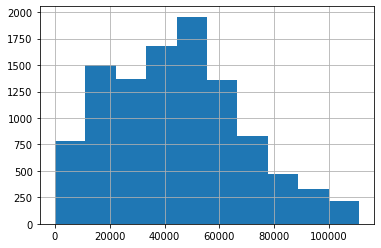

In [ ]:
# Custom line in EPSG:31984 CRS
l_costa = LineString([(700193.83391362486872822, 8763788.64822966419160366),
                  (686834.44766193581745028, 8746861.22714056819677353), 
                  (683515.34548760310281068, 8735493.30219347961246967), 
                  (675383.54516048799268901, 8726697.68143149651587009), 
                  (657418.90464191255159676, 8691100.3106117807328701)])

untrd['dist_mar'] = untrd.distance(l_costa)
untrd.dist_mar.hist()

## Feature generation based on spatial search trees

### Object density calculation

We are using cKDTree to generate spatial search trees, this will allow us perform searchs around each object. Let's see two ways to use them.

In [6]:
# We are going to use
from scipy.spatial import cKDTree

The first method is to define a radius around a point and get all the points inside the circle defined. This is some sort of density of objetcs around de reference.

In our case we want to know how many low-tension consumers there are around each transformer. So, first we load the consumers data.

In [ ]:
ucbt = gpd.read_file(data_path, driver='FileGDB', layer='UCBT')
ucbt = ucbt.to_crs(epsg=31984)

To create the tree we must pass an array with the dimentions

In [ ]:
# In order t
ucbt_loc_array = [x.coords[0] for x in ucbt.geometry]
untrd_loc_array = [x.coords[0] for x in untrd.geometry]

Let's use a 100 meters radius

In [ ]:
radio = 100
tree = cKDTree(ucbt_loc_array)
near_consumers = tree.query_ball_point(untrd_loc_array, radio)

This will return a list of indices for each transformer

In [ ]:
near_consumers[0:10]

array([list([100083]), list([104711]),
       list([5543, 5545, 5549, 5550, 5551, 5552, 5553, 5674, 5675, 5676, 5677, 5678, 5679, 8463, 8464, 14893, 14894, 15649, 15650, 15651, 15652, 15653, 15654, 15655, 15656, 15657, 15658, 15668, 15669, 15670, 15671, 15672, 15673, 15674, 15675, 15676, 15677, 15678, 15692, 15693, 15694, 15931, 15950, 15951, 15953, 15955, 15970, 15971, 15973, 15974, 15975, 15976, 15990, 15991, 15992, 16000, 16019, 16020, 16036, 16084, 16400, 16413, 16416, 17404, 23409, 23702, 31180, 39167, 39168, 39894, 40524, 40558, 40664, 41591, 42018, 42122, 42123, 44123, 44418, 44419, 44502, 44889, 45015, 45055, 46516, 51701, 64254, 64987, 64988, 65398, 65519, 66227, 66546, 66812, 66813, 66815, 66816, 66817, 67214, 67437, 67438, 67439, 67441, 67912, 67913, 67915, 69389, 69473, 69474, 69493, 69494, 69496, 69497, 69545, 69546, 69547, 69551, 69552, 69553, 69554, 69555, 70018, 70019, 70020, 70021, 70022, 70188, 99972, 107219, 107747, 114274, 114303, 117881, 118208, 120014, 120015, 120

And now we can create features aggregating this lists of lists.

In [ ]:
# Amount of consumers in 100 meters radius
untrd['n_close_con'] = [len(c) for c in near_consumers]

# Is there more than 50 consumers in 100 meters radius
untrd['is_urb'] =  untrd['n_close_con'] > 50

### Distance to closest object

The second approach we could use is to get the distance to the k closest elemets on the tree.

So this time will calculate the distance to the new transformer.

In [ ]:
trd_tree = cKDTree(untrd_loc_array)
d, i = trd_tree.query(untrd_loc_array, k=2, n_jobs=-1)

We want to know the closest element, however we set k=2 because the first will be the transformer itself.

In this case the query will return two lists of lenght k (2 in this case) lists. One will contain the distances and the other the indices of the correspondent element.

In [ ]:
d[:5]

array([[  0.        , 182.47357502],
       [  0.        , 668.68191247],
       [  0.        ,  35.66382543],
       [  0.        , 191.94049967],
       [  0.        ,  58.1663477 ]])

So now again we use the result to generate new features

In [ ]:
untrd['closest_trd_i'] = [ti[1] for ti in i]
untrd['closest_trd_dist'] = [td[1] for td in d]

In [ ]:
untrd.head()

,COD_ID,DIST,PAC_1,PAC_2,PAC_3,FAS_CON_P,FAS_CON_S,FAS_CON_T,SIT_ATIV,TIP_UNID,POS,ATRB_PER,TEN_LIN_SE,CAP_ELO,CAP_CHA,TAP,CONF,POSTO,POT_NOM,PER_FER,PER_TOT,DAT_CON,CTMT,UNI_TR_S,SUB,CONJ,MUN,BANC,TIP_TRAFO,MRT,DESCR,ARE_LOC,geometry,eu_dis_trs,dist_mar,main_r_dist,closest_trd_i,closest_trd_dist
0,4_1040341,46,452971,ET4_1040341,0,ABC,ABCN,0,AT,38,PD,1,0.22,05H,1,1.0,RA,PT,15.0,100.0,440.0,30/09/2010,2_SESAQ_1,1_SESAQ_1,SESAQ,12737,2805802,0,T,0,,NU,POINT (627712.617 8776098.670),6030.232571,65956.189519,3868.829691,2054,182.473575
1,4_1040306,46,452681,ET4_1040306,0,ABC,ABCN,0,AT,38,PD,1,0.22,05H,1,1.0,RA,PT,15.0,100.0,440.0,15/03/2011,2_SESAQ_1,1_SESAQ_1,SESAQ,12737,2805802,0,T,0,,NU,POINT (626353.418 8777498.606),6839.156041,67798.259119,5529.165862,4111,668.681912
2,7_2070013,46,600021,ET7_2070013,0,ABC,ABCN,0,AT,38,O,2,0.38,5H,1,1.0,RA,PT,112.5,440.0,1990.0,30/09/2010,1_SEITI_1,1_SEITI_1,SEITI,15601,2803005,0,T,0,,UB,POINT (632355.415 8753247.956),802.511258,50560.232126,1.977559,6269,35.663825
3,4_1040035,46,462831,ET4_1040035,ET4_1040035,AB,AN,BN,AT,38,PD,1,0.23,1H,1,1.0,RA,PT,15.0,85.0,355.0,30/09/2010,2_SESAQ_1,1_SESAQ_1,SESAQ,12737,2805802,0,MT,0,,NU,POINT (635724.137 8773322.662),11259.764183,57554.073637,1420.588809,8962,191.940500
4,13_1130368,46,148261,ET13_1130368,0,ABC,ABCN,0,AT,38,PD,1,0.38,2H,1,1.0,RA,PT,45.0,220.0,1000.0,18/10/2013,1_SETMG_1,2_SETMG_1,SETMG,12743,2917904,0,T,0,,NU,POINT (631104.558 8720058.235),23063.913506,36539.002419,5473.898753,5214,58.166348


## Conclutions

In this post we learn how to capture location and convert it in structure features that can be feed to a Machine Learning algorithm, using mainly distances to keypoints and references.

In the next post we'll see how we can use OSMnx to download information from OpenStreet Maps and use it as reference.